In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
plt.style.use('/raid/lingo/akyurek/mplstyle')
plt.rc('font', serif='Times')
plt.rc('text', usetex=False)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.facecolor'] = 'white'
"""Google cloud directory that stores results of the experiments"""
BASE_DIR = "./"
METRICS_DIR = os.path.join(BASE_DIR, "metrics")

In [2]:
pd.__version__

'1.3.5'

In [3]:
def average_metrics(results):
    """Average the metrics over samples"""
    metrics = {'precision': {}, 'recall': {}}
    for k in (1, 5, 10,  50, 100):
        if type(list(results[0]['precision'].keys())[0]) == str:
            k = str(k)
        metrics['precision'][k] = np.mean([res['precision'][k] for res in results])
        metrics['recall'][k] = np.mean([res['recall'][k] for res in results])
    metrics['mrr'] = np.mean([res['rr'] for res in results])
    metrics['samples'] = results
    return metrics

In [4]:
def metrics_to_df(metrics):
    info = copy.deepcopy(metrics)
    for normalization, results in info.items():
        for method, method_results in results.items():
            for layer_config, result in method_results.items():
                if 'samples' in result:
                    del result['samples']
                    result['mrr'] = {'1': result['mrr']}
    df = pd.DataFrame(pd.json_normalize(info, sep="+")).transpose()
    df.index = pd.MultiIndex.from_tuples([tuple(k.split("+")) for k, v in df.iterrows()])
    df = pd.melt(df.transpose())
    df.columns = ['normalization', 'eval', 'layers', 'metrics', 'k', 'score']
    df['layer_type'] = 'A'
    df.loc[df['layers'].str.contains('gradients'), 'layer_type'] = 'gradients'
    df.loc[(df['layers'].str.contains('gradients')) & (df['layers'].str.contains('activations')), 'layer_type'] = 'gradients_and_activations'
    df.loc[(df['layers'] == 'random') | (df['layers'] == 'bm25plus'), 'layer_type'] = 'baseline'
    
    df = df.replace({'gradients':'G', 
                     'activations': 'A',
                     'block.': '', 
                     'encoder': 'E', 
                     'decoder': 'D', 
                     'shared': 'emb', 
                     'random': 'Target-Picker'}, regex=True)
    return df

In [6]:
def visualize_one_experiment(paths, 
                             suffix="", 
                             folder="plots/",
                             show=True,
                             return_df=False):
  
    dfs = []
    for (i, path) in enumerate(paths):
        with open(METRICS_DIR + path) as f:
            reranker_metrics = json.load(f)
        
        df = metrics_to_df(reranker_metrics)
        df = df[~df['layers'].str.contains('A.E.0,A.D.0,')]
        df['seed'] = i
        dfs.append(df)
      
    df = pd.concat(dfs, ignore_index=True)
    # scores = df.groupby(['normalization', 'eval', 'layers', 'metrics', 'k']).agg({'score': ['mean', 'std']}, as_index=False)
    
    # return df, scores
    
    
    if return_df:
        return df
    for method in ("full", "collapse"):
      
      plot_with_filter(df, 
                       filter=lambda x: x[(x['metrics'] == 'precision') & (x['k'] == '3')  & (x['eval'] == method)],
                       title=f'precision@3 ({method} + {suffix})',
                       folder=folder,
                       show=show)
      
      plot_with_filter(df,
                       filter=lambda x: x[(x['metrics'] == 'recall') & (x['k'] == '3') & (x['eval'] == method)],
                       title=f'recall@3 ({method} + {suffix})',
                       folder=folder,
                       show=show)
      
      plot_with_filter(df,
                       filter=lambda x: x[(x['metrics'] == 'mrr') & (x['k'] == '1') & (x['eval'] == method)],
                       title=f'mrr ({method} + {suffix})',
                       folder=folder,
                       show=show)
  

In [154]:
sdf  = visualize_one_experiment(paths=[f'/reranker/exp_layers_{i}/ln_sl_no_eos__learned_accum.json'
                                     for i in range(3)
                                     ], 
                              suffix="", 
                              show=False, 
                              return_df=True)

In [155]:
sdf.head()

,normalization,eval,layers,metrics,k,score,layer_type,seed
0,cosine,collapse,G.emb,precision,1,0.490,G,0
1,cosine,collapse,G.emb,precision,3,0.360,G,0
2,cosine,collapse,G.emb,precision,5,0.302,G,0
3,cosine,collapse,G.emb,precision,10,0.230,G,0
4,cosine,collapse,G.emb,precision,25,0.162,G,0


In [156]:
sdf['layer_type'] = sdf['layer_type'].replace({'G': 'TracIn', 
                           'A': 'Embed', 
                           'G_and_A': 'TracIn+Embed',
                           'baseline': 'Baselines'
                          })

In [157]:
sdf['layers'] = sdf['layers'].replace({f'G.E.{i},G.D.{i}': f'G.E.{i+1},G.D.{i+1}' for i in range(12)})\
             .replace({f'G.E.{i}': f'G.E.{i+1}' for i in range(12)})\
             .replace({f'G.emb,G.E.{i},G.D.{i}': f'G.emb,G.E.{i+1},G.D.{i+1}' for i in range(12)})\
             .replace({f'G.emb,G.E.{i}': f'G.emb,G.E.{i+1}' for i in range(12)})\
             .str.replace('G.emb', 'G.0').str.replace('bm25plus','BM25+').str.replace('Target-Picker', 'Random-Target')
             

/raid/lingo/akyurek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


In [158]:
sdf.head()

,normalization,eval,layers,metrics,k,score,layer_type,seed
0,cosine,collapse,G.0,precision,1,0.490,TracIn,0
1,cosine,collapse,G.0,precision,3,0.360,TracIn,0
2,cosine,collapse,G.0,precision,5,0.302,TracIn,0
3,cosine,collapse,G.0,precision,10,0.230,TracIn,0
4,cosine,collapse,G.0,precision,25,0.162,TracIn,0


In [162]:
def plot_with_filter(df, filter=lambda x: x, title="Title", folder="plots/", show=True):
    plt.figure(figsize=(16, 6))
    ax = sns.barplot(data=filter(df), 
                x='layers', 
                y='score', 
                hue='layer_type', 
                estimator=np.mean, 
                ci='sd')
    plt.xticks(rotation=90)
    plt.title(title)
    plt.xlabel("Layer Selection")
    plt.ylabel("Recall@10")
    plt.legend(title='Method Type')
    if show:
        plt.show()
    else:
        plt.savefig(folder+title+"_plot.png")

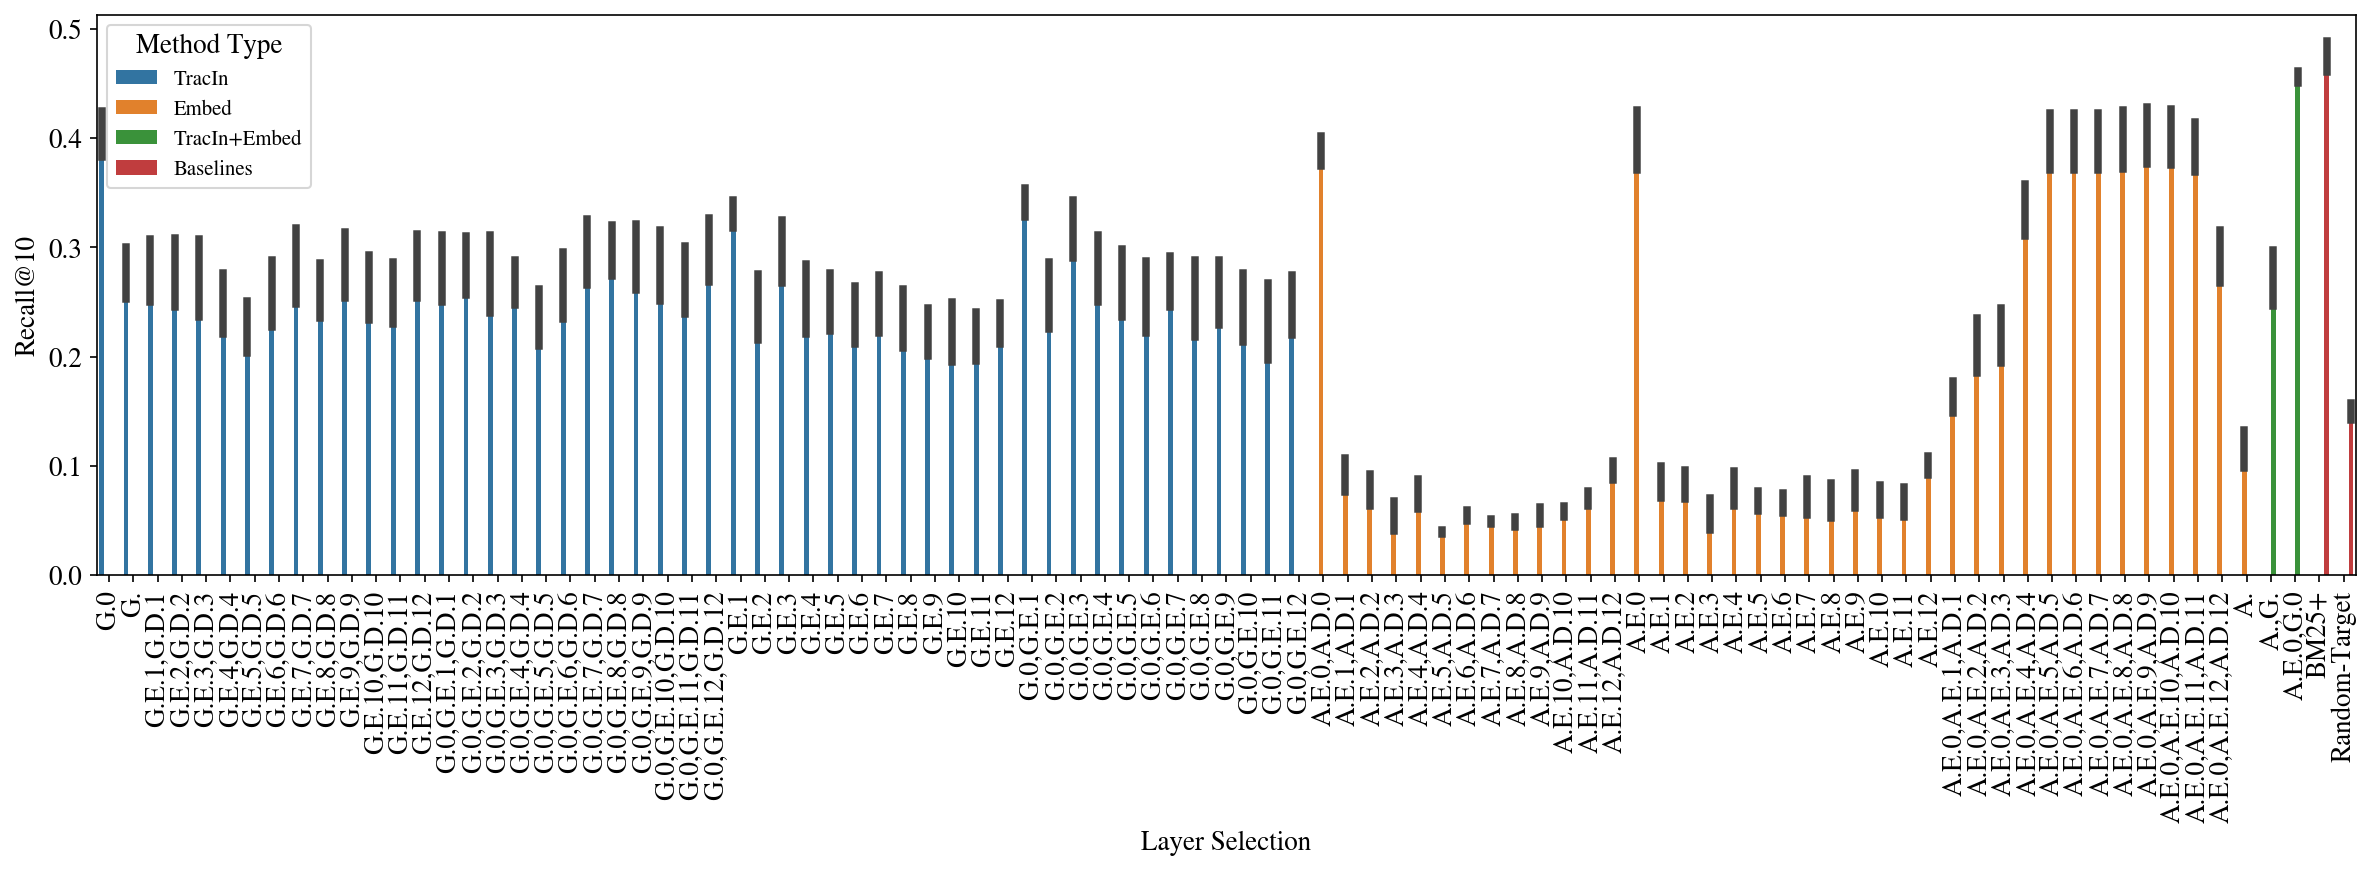

In [163]:
plot_with_filter(sdf,
                filter=lambda x: x[(x['metrics'] == 'recall') & (x['k'] == '10') & (x['eval'] == 'collapse') & (x['normalization'] == 'cosine')],
                title='',
                show=False,
                folder="./paper_figures/")

In [33]:
df

{}

In [139]:
df = {}
for norm_type in ("ln", ):
    for eos in ("eos", ):
        for subset in ("learned", ):
            for accum in ("no_accum", "accum"):
                try:
                    suffix=f"{norm_type}+{eos}+{subset}+{accum}"
                    df[suffix]=visualize_one_experiment(paths=[f'/reranker/exp_layers_{i}/{norm_type}_sl_{eos}__{subset}_{accum}.json'
                                                               for i in range(2)], 
                                                        suffix=suffix, 
                                                        show=False, 
                                                        return_df=True)
                except FileNotFoundError:
                    print(f'notfound: /reranker/exp_layers/{norm_type}_sl_{eos}__{subset}_{accum}.json')

notfound: /reranker/exp_layers/ln_sl_eos__learned_no_accum.json


In [140]:
for (k, v) in df.items():
    norm_type, eos, subset, accum = k.split('+')
    v['norm_type'] = norm_type
    v['eos'] = eos
    v['subset'] = subset
    v['accum'] = accum
    

In [141]:
dfmerged = pd.concat(df.values(), ignore_index=False)

In [142]:
dfmerged.head()

,normalization,eval,layers,metrics,k,score,layer_type,seed,norm_type,eos,subset,accum
0,cosine,collapse,G.emb,precision,1,0.260000,G,0,ln,eos,learned,accum
1,cosine,collapse,G.emb,precision,3,0.236667,G,0,ln,eos,learned,accum
2,cosine,collapse,G.emb,precision,5,0.202000,G,0,ln,eos,learned,accum
3,cosine,collapse,G.emb,precision,10,0.179000,G,0,ln,eos,learned,accum
4,cosine,collapse,G.emb,precision,25,0.146400,G,0,ln,eos,learned,accum


In [143]:
scores = dfmerged.groupby(['normalization', 'eval', 'layers', 'metrics', 'k', 'layer_type', 'norm_type', 'eos', 'subset', 'accum']).agg({'score': ['mean', 'std']}, as_index=False)
scores = scores.reset_index()
    

In [144]:
scores

normalization      eval    layers    metrics   k layer_type norm_type  \
                                                                             
0     cosine        collapse  A.        mrr        1   A          ln         
1     cosine        collapse  A.        precision  1   A          ln         
2     cosine        collapse  A.        precision  10  A          ln         
3     cosine        collapse  A.        precision  25  A          ln         
4     cosine        collapse  A.        precision  3   A          ln         
...      ...             ...  ..              ...  .. ..          ..         
4087  dot           full      bm25plus  recall     1   baseline   ln         
4088  dot           full      bm25plus  recall     10  baseline   ln         
4089  dot           full      bm25plus  recall     25  baseline   ln         
4090  dot           full      bm25plus  recall     3   baseline   ln         
4091  dot           full      bm25plus  recall     5   baseline   ln         

      eos   subset  accum     score            
                               mean       std  
0     eos  learned  accum  0.225262  0.041075  
1     eos  learned  accum  0.140000  0.042426  
2     eos  learned  accum  0.096500  0.003536  
3     eos  learned  accum  0.089600  0.006223  
4     eos  learned  accum  0.110000  0.018856  
...   ...      ...    ...       ...       ...  
4087  eos  learned  accum  0.131270  0.008214  
4088  eos  learned  accum  0.414216  0.027174  
4089  eos  learned  accum  0.511498  0.025348  
4090  eos  learned  accum  0.295075  0.008833  
4091  eos  learned  accum  0.354095  0.002403  

[4092 rows x 12 columns]

In [148]:
def get_max(df: pd.DataFrame, prefix, no_prefix=None, subset='learned', metric='mrr', eval_type='collapse', k='1'):
    df2 = df[(df['layers'].str.startswith(prefix)) & (df['subset'] == subset) & (df['metrics'] == metric) & (df['k'] == str(k)) & (df['eval'] == eval_type)]
    if no_prefix:
        df2 = df2[~df2['layers'].str.contains(no_prefix)]
    nlargest = df2.nlargest(20, ('score', 'mean'))
    largest = nlargest.iloc[0]    
    dflargest = df[(df['layers'] == largest['layers'][0]) & (df['norm_type'] == largest['norm_type'][0]) & (df['eos'] == largest['eos'][0]) &  (df['accum'] == largest['accum'][0]) &(df['subset'] == subset) & (df['eval'] == eval_type)]
    return nlargest, dflargest


In [149]:
largest, dflargest = get_max(scores, 'A', no_prefix='G')
display(largest)
display(dflargest)

normalization      eval               layers metrics  k layer_type  \
                                                                          
33    cosine        collapse  A.E.0,A.D.0          mrr     1  A           
55    cosine        collapse  A.E.0,A.E.10,A.D.10  mrr     1  A           
165   cosine        collapse  A.E.0,A.E.9,A.D.9    mrr     1  A           
154   cosine        collapse  A.E.0,A.E.8,A.D.8    mrr     1  A           
143   cosine        collapse  A.E.0,A.E.7,A.D.7    mrr     1  A           
...      ...             ...                ...    ...    .. ..           
2068  dot           collapse  A.E.0                mrr     1  A           
44    cosine        collapse  A.E.0,A.E.1,A.D.1    mrr     1  A           
2299  dot           collapse  A.E.12               mrr     1  A           
0     cosine        collapse  A.                   mrr     1  A           
264   cosine        collapse  A.E.12,A.D.12        mrr     1  A           

     norm_type  eos   subset  accum     score            
                                         mean       std  
33    ln        eos  learned  accum  0.466195  0.036123  
55    ln        eos  learned  accum  0.452291  0.054790  
165   ln        eos  learned  accum  0.451610  0.055558  
154   ln        eos  learned  accum  0.449461  0.055677  
143   ln        eos  learned  accum  0.448948  0.050727  
...   ..        ...      ...    ...       ...       ...  
2068  ln        eos  learned  accum  0.280658  0.017699  
44    ln        eos  learned  accum  0.246383  0.027886  
2299  ln        eos  learned  accum  0.239844  0.010089  
0     ln        eos  learned  accum  0.225262  0.041075  
264   ln        eos  learned  accum  0.222988  0.000945  

[20 rows x 12 columns]

normalization      eval       layers    metrics   k layer_type norm_type  \
                                                                                
33    cosine        collapse  A.E.0,A.D.0  mrr        1   A          ln         
34    cosine        collapse  A.E.0,A.D.0  precision  1   A          ln         
35    cosine        collapse  A.E.0,A.D.0  precision  10  A          ln         
36    cosine        collapse  A.E.0,A.D.0  precision  25  A          ln         
37    cosine        collapse  A.E.0,A.D.0  precision  3   A          ln         
...      ...             ...          ...        ...  .. ..          ..         
2085  dot           collapse  A.E.0,A.D.0  recall     1   A          ln         
2086  dot           collapse  A.E.0,A.D.0  recall     10  A          ln         
2087  dot           collapse  A.E.0,A.D.0  recall     25  A          ln         
2088  dot           collapse  A.E.0,A.D.0  recall     3   A          ln         
2089  dot           collapse  A.E.0,A.D.0  recall     5   A          ln         

      eos   subset  accum     score            
                               mean       std  
33    eos  learned  accum  0.466195  0.036123  
34    eos  learned  accum  0.335000  0.021213  
35    eos  learned  accum  0.205500  0.003536  
36    eos  learned  accum  0.154400  0.000566  
37    eos  learned  accum  0.280000  0.042426  
...   ...      ...    ...       ...       ...  
2085  eos  learned  accum  0.047810  0.016263  
2086  eos  learned  accum  0.236146  0.043731  
2087  eos  learned  accum  0.407120  0.053779  
2088  eos  learned  accum  0.105122  0.016583  
2089  eos  learned  accum  0.157560  0.009639  

[22 rows x 12 columns]

In [150]:
largest, dflargest = get_max(scores, 'A')
display(largest)
display(dflargest)

normalization      eval               layers metrics  k layer_type  \
                                                                          
33    cosine        collapse  A.E.0,A.D.0          mrr     1  A           
176   cosine        collapse  A.E.0,G.emb          mrr     1  G_and_A     
55    cosine        collapse  A.E.0,A.E.10,A.D.10  mrr     1  A           
165   cosine        collapse  A.E.0,A.E.9,A.D.9    mrr     1  A           
154   cosine        collapse  A.E.0,A.E.8,A.D.8    mrr     1  A           
...      ...             ...                ...    ...    .. ..           
2057  dot           collapse  A.,G.                mrr     1  G_and_A     
88    cosine        collapse  A.E.0,A.E.2,A.D.2    mrr     1  A           
2123  dot           collapse  A.E.0,A.E.12,A.D.12  mrr     1  A           
2068  dot           collapse  A.E.0                mrr     1  A           
11    cosine        collapse  A.,G.                mrr     1  G_and_A     

     norm_type  eos   subset  accum     score            
                                         mean       std  
33    ln        eos  learned  accum  0.466195  0.036123  
176   ln        eos  learned  accum  0.463492  0.079701  
55    ln        eos  learned  accum  0.452291  0.054790  
165   ln        eos  learned  accum  0.451610  0.055558  
154   ln        eos  learned  accum  0.449461  0.055677  
...   ..        ...      ...    ...       ...       ...  
2057  ln        eos  learned  accum  0.295904  0.021031  
88    ln        eos  learned  accum  0.292174  0.057220  
2123  ln        eos  learned  accum  0.291136  0.004895  
2068  ln        eos  learned  accum  0.280658  0.017699  
11    ln        eos  learned  accum  0.278816  0.026805  

[20 rows x 12 columns]

normalization      eval       layers    metrics   k layer_type norm_type  \
                                                                                
33    cosine        collapse  A.E.0,A.D.0  mrr        1   A          ln         
34    cosine        collapse  A.E.0,A.D.0  precision  1   A          ln         
35    cosine        collapse  A.E.0,A.D.0  precision  10  A          ln         
36    cosine        collapse  A.E.0,A.D.0  precision  25  A          ln         
37    cosine        collapse  A.E.0,A.D.0  precision  3   A          ln         
...      ...             ...          ...        ...  .. ..          ..         
2085  dot           collapse  A.E.0,A.D.0  recall     1   A          ln         
2086  dot           collapse  A.E.0,A.D.0  recall     10  A          ln         
2087  dot           collapse  A.E.0,A.D.0  recall     25  A          ln         
2088  dot           collapse  A.E.0,A.D.0  recall     3   A          ln         
2089  dot           collapse  A.E.0,A.D.0  recall     5   A          ln         

      eos   subset  accum     score            
                               mean       std  
33    eos  learned  accum  0.466195  0.036123  
34    eos  learned  accum  0.335000  0.021213  
35    eos  learned  accum  0.205500  0.003536  
36    eos  learned  accum  0.154400  0.000566  
37    eos  learned  accum  0.280000  0.042426  
...   ...      ...    ...       ...       ...  
2085  eos  learned  accum  0.047810  0.016263  
2086  eos  learned  accum  0.236146  0.043731  
2087  eos  learned  accum  0.407120  0.053779  
2088  eos  learned  accum  0.105122  0.016583  
2089  eos  learned  accum  0.157560  0.009639  

[22 rows x 12 columns]

In [153]:
largest, dflargest = get_max(scores, 'G')
display(largest)
display(dflargest)

normalization      eval               layers metrics  k layer_type  \
                                                                          
726   cosine        collapse  G.emb                mrr     1  G           
2772  dot           collapse  G.emb                mrr     1  G           
2585  dot           collapse  G.E.11,G.D.11        mrr     1  G           
2860  dot           collapse  G.emb,G.E.11,G.D.11  mrr     1  G           
803   cosine        collapse  G.emb,G.E.11         mrr     1  G           
3036  dot           collapse  G.emb,G.E.9,G.D.9    mrr     1  G           
2761  dot           collapse  G.E.9,G.D.9          mrr     1  G           
737   cosine        collapse  G.emb,G.E.0          mrr     1  G           
3014  dot           collapse  G.emb,G.E.8,G.D.8    mrr     1  G           
2739  dot           collapse  G.E.8,G.D.8          mrr     1  G           
2838  dot           collapse  G.emb,G.E.10,G.D.10  mrr     1  G           
2816  dot           collapse  G.emb,G.E.1,G.D.1    mrr     1  G           
2541  dot           collapse  G.E.1,G.D.1          mrr     1  G           
3003  dot           collapse  G.emb,G.E.8          mrr     1  G           
2981  dot           collapse  G.emb,G.E.7          mrr     1  G           
2728  dot           collapse  G.E.8                mrr     1  G           
759   cosine        collapse  G.emb,G.E.1          mrr     1  G           
2563  dot           collapse  G.E.10,G.D.10        mrr     1  G           
2805  dot           collapse  G.emb,G.E.1          mrr     1  G           
2783  dot           collapse  G.emb,G.E.0          mrr     1  G           

     norm_type  eos   subset  accum     score            
                                         mean       std  
726   ln        eos  learned  accum  0.355069  0.023632  
2772  ln        eos  learned  accum  0.334423  0.047373  
2585  ln        eos  learned  accum  0.328505  0.026356  
2860  ln        eos  learned  accum  0.327550  0.026299  
803   ln        eos  learned  accum  0.319867  0.020136  
3036  ln        eos  learned  accum  0.316502  0.018894  
2761  ln        eos  learned  accum  0.315835  0.018960  
737   ln        eos  learned  accum  0.314455  0.039459  
3014  ln        eos  learned  accum  0.314446  0.026955  
2739  ln        eos  learned  accum  0.313447  0.025932  
2838  ln        eos  learned  accum  0.313425  0.026011  
2816  ln        eos  learned  accum  0.312951  0.024239  
2541  ln        eos  learned  accum  0.312893  0.024281  
3003  ln        eos  learned  accum  0.312884  0.029376  
2981  ln        eos  learned  accum  0.312422  0.029910  
2728  ln        eos  learned  accum  0.312247  0.027991  
759   ln        eos  learned  accum  0.311108  0.022122  
2563  ln        eos  learned  accum  0.310187  0.026458  
2805  ln        eos  learned  accum  0.308039  0.021296  
2783  ln        eos  learned  accum  0.307786  0.042022

normalization      eval layers    metrics   k layer_type norm_type  eos  \
                                                                               
726   cosine        collapse  G.emb  mrr        1   G          ln        eos   
727   cosine        collapse  G.emb  precision  1   G          ln        eos   
728   cosine        collapse  G.emb  precision  10  G          ln        eos   
729   cosine        collapse  G.emb  precision  25  G          ln        eos   
730   cosine        collapse  G.emb  precision  3   G          ln        eos   
731   cosine        collapse  G.emb  precision  5   G          ln        eos   
732   cosine        collapse  G.emb  recall     1   G          ln        eos   
733   cosine        collapse  G.emb  recall     10  G          ln        eos   
734   cosine        collapse  G.emb  recall     25  G          ln        eos   
735   cosine        collapse  G.emb  recall     3   G          ln        eos   
736   cosine        collapse  G.emb  recall     5   G          ln        eos   
2772  dot           collapse  G.emb  mrr        1   G          ln        eos   
2773  dot           collapse  G.emb  precision  1   G          ln        eos   
2774  dot           collapse  G.emb  precision  10  G          ln        eos   
2775  dot           collapse  G.emb  precision  25  G          ln        eos   
2776  dot           collapse  G.emb  precision  3   G          ln        eos   
2777  dot           collapse  G.emb  precision  5   G          ln        eos   
2778  dot           collapse  G.emb  recall     1   G          ln        eos   
2779  dot           collapse  G.emb  recall     10  G          ln        eos   
2780  dot           collapse  G.emb  recall     25  G          ln        eos   
2781  dot           collapse  G.emb  recall     3   G          ln        eos   
2782  dot           collapse  G.emb  recall     5   G          ln        eos   

       subset  accum     score            
                          mean       std  
726   learned  accum  0.355069  0.023632  
727   learned  accum  0.255000  0.007071  
728   learned  accum  0.175000  0.005657  
729   learned  accum  0.150600  0.005940  
730   learned  accum  0.215000  0.030641  
731   learned  accum  0.190000  0.016971  
732   learned  accum  0.049466  0.007993  
733   learned  accum  0.250044  0.022652  
734   learned  accum  0.487099  0.019734  
735   learned  accum  0.111189  0.016376  
736   learned  accum  0.145105  0.015982  
2772  learned  accum  0.334423  0.047373  
2773  learned  accum  0.230000  0.056569  
2774  learned  accum  0.178000  0.007071  
2775  learned  accum  0.150800  0.005657  
2776  learned  accum  0.196667  0.014142  
2777  learned  accum  0.192000  0.011314  
2778  learned  accum  0.040587  0.018582  
2779  learned  accum  0.236165  0.034660  
2780  learned  accum  0.427231  0.022350  
2781  learned  accum  0.098175  0.013440  
2782  learned  accum  0.139588  0.022063

In [138]:
largest, dflargest = get_max(scores, 'bm25')
display(largest)
display(dflargest)

normalization      eval    layers metrics  k layer_type norm_type  \
                                                                         
1012  cosine        collapse  bm25plus  mrr     1  baseline   ln         
3058  dot           collapse  bm25plus  mrr     1  baseline   ln         

         eos  subset     accum     score            
                                    mean       std  
1012  no_eos  random  no_accum  0.745132  0.004221  
3058  no_eos  random  no_accum  0.745132  0.004221

normalization      eval    layers    metrics   k layer_type norm_type  \
                                                                             
1012  cosine        collapse  bm25plus  mrr        1   baseline   ln         
1013  cosine        collapse  bm25plus  precision  1   baseline   ln         
1014  cosine        collapse  bm25plus  precision  10  baseline   ln         
1015  cosine        collapse  bm25plus  precision  25  baseline   ln         
1016  cosine        collapse  bm25plus  precision  3   baseline   ln         
...      ...             ...       ...        ...  ..       ...   ..         
3064  dot           collapse  bm25plus  recall     1   baseline   ln         
3065  dot           collapse  bm25plus  recall     10  baseline   ln         
3066  dot           collapse  bm25plus  recall     25  baseline   ln         
3067  dot           collapse  bm25plus  recall     3   baseline   ln         
3068  dot           collapse  bm25plus  recall     5   baseline   ln         

         eos  subset     accum     score            
                                    mean       std  
1012  no_eos  random  no_accum  0.745132  0.004221  
1013  no_eos  random  no_accum  0.690000  0.028284  
1014  no_eos  random  no_accum  0.222000  0.002828  
1015  no_eos  random  no_accum  0.137000  0.021779  
1016  no_eos  random  no_accum  0.425000  0.021213  
...      ...     ...       ...       ...       ...  
3064  no_eos  random  no_accum  0.302429  0.019732  
3065  no_eos  random  no_accum  0.508143  0.022073  
3066  no_eos  random  no_accum  0.592629  0.039971  
3067  no_eos  random  no_accum  0.411433  0.023290  
3068  no_eos  random  no_accum  0.450701  0.019607  

[22 rows x 12 columns]

In [146]:
largest, dflargest  = get_max(scores, 'Target-Picker')
display(largest)
display(dflargest)

normalization      eval         layers metrics  k layer_type norm_type  \
                                                                              
2002  cosine        collapse  Target-Picker  mrr     1  baseline   ln         
6094  dot           collapse  Target-Picker  mrr     1  baseline   ln         

         eos   subset  accum     score            
                                  mean       std  
2002  no_eos  learned  accum  0.251863  0.042307  
6094  no_eos  learned  accum  0.251863  0.042307

normalization      eval         layers    metrics   k layer_type  \
                                                                        
2002  cosine        collapse  Target-Picker  mrr        1   baseline    
2004  cosine        collapse  Target-Picker  precision  1   baseline    
2006  cosine        collapse  Target-Picker  precision  10  baseline    
2008  cosine        collapse  Target-Picker  precision  25  baseline    
2010  cosine        collapse  Target-Picker  precision  3   baseline    
2012  cosine        collapse  Target-Picker  precision  5   baseline    
2014  cosine        collapse  Target-Picker  recall     1   baseline    
2016  cosine        collapse  Target-Picker  recall     10  baseline    
2018  cosine        collapse  Target-Picker  recall     25  baseline    
2020  cosine        collapse  Target-Picker  recall     3   baseline    
2022  cosine        collapse  Target-Picker  recall     5   baseline    
6094  dot           collapse  Target-Picker  mrr        1   baseline    
6096  dot           collapse  Target-Picker  precision  1   baseline    
6098  dot           collapse  Target-Picker  precision  10  baseline    
6100  dot           collapse  Target-Picker  precision  25  baseline    
6102  dot           collapse  Target-Picker  precision  3   baseline    
6104  dot           collapse  Target-Picker  precision  5   baseline    
6106  dot           collapse  Target-Picker  recall     1   baseline    
6108  dot           collapse  Target-Picker  recall     10  baseline    
6110  dot           collapse  Target-Picker  recall     25  baseline    
6112  dot           collapse  Target-Picker  recall     3   baseline    
6114  dot           collapse  Target-Picker  recall     5   baseline    

     norm_type     eos   subset  accum     score            
                                            mean       std  
2002  ln        no_eos  learned  accum  0.251863  0.042307  
2004  ln        no_eos  learned  accum  0.130000  0.051962  
2006  ln        no_eos  learned  accum  0.131667  0.018448  
2008  ln        no_eos  learned  accum  0.121467  0.012095  
2010  ln        no_eos  learned  accum  0.144444  0.025240  
2012  ln        no_eos  learned  accum  0.142000  0.021166  
2014  ln        no_eos  learned  accum  0.019309  0.010635  
2016  ln        no_eos  learned  accum  0.149687  0.009599  
2018  ln        no_eos  learned  accum  0.351295  0.023095  
2020  ln        no_eos  learned  accum  0.060113  0.012926  
2022  ln        no_eos  learned  accum  0.086198  0.017178  
6094  ln        no_eos  learned  accum  0.251863  0.042307  
6096  ln        no_eos  learned  accum  0.130000  0.051962  
6098  ln        no_eos  learned  accum  0.131667  0.018448  
6100  ln        no_eos  learned  accum  0.121467  0.012095  
6102  ln        no_eos  learned  accum  0.144444  0.025240  
6104  ln        no_eos  learned  accum  0.142000  0.021166  
6106  ln        no_eos  learned  accum  0.019309  0.010635  
6108  ln        no_eos  learned  accum  0.149687  0.009599  
6110  ln        no_eos  learned  accum  0.351295  0.023095  
6112  ln        no_eos  learned  accum  0.060113  0.012926  
6114  ln        no_eos  learned  accum  0.086198  0.017178

In [121]:
largest, dflargest = get_max(scores, 'A', no_prefix='G', subset='random')
display(largest)
display(dflargest)

normalization      eval               layers metrics  k layer_type  \
                                                                          
232   cosine        collapse  A.E.0,A.D.0          mrr     1  A           
233   cosine        collapse  A.E.0,A.D.0          mrr     1  A           
540   cosine        collapse  A.E.0,A.E.12,A.D.12  mrr     1  A           
541   cosine        collapse  A.E.0,A.E.12,A.D.12  mrr     1  A           
1160  cosine        collapse  A.E.0,A.E.9,A.D.9    mrr     1  A           
1161  cosine        collapse  A.E.0,A.E.9,A.D.9    mrr     1  A           
1083  cosine        collapse  A.E.0,A.E.8,A.D.8    mrr     1  A           
1084  cosine        collapse  A.E.0,A.E.8,A.D.8    mrr     1  A           
1006  cosine        collapse  A.E.0,A.E.7,A.D.7    mrr     1  A           
1007  cosine        collapse  A.E.0,A.E.7,A.D.7    mrr     1  A           
929   cosine        collapse  A.E.0,A.E.6,A.D.6    mrr     1  A           
930   cosine        collapse  A.E.0,A.E.6,A.D.6    mrr     1  A           
852   cosine        collapse  A.E.0,A.E.5,A.D.5    mrr     1  A           
853   cosine        collapse  A.E.0,A.E.5,A.D.5    mrr     1  A           
155   cosine        collapse  A.E.0                mrr     1  A           
156   cosine        collapse  A.E.0                mrr     1  A           
159   cosine        collapse  A.E.0                mrr     1  A           
160   cosine        collapse  A.E.0                mrr     1  A           
390   cosine        collapse  A.E.0,A.E.10,A.D.10  mrr     1  A           
391   cosine        collapse  A.E.0,A.E.10,A.D.10  mrr     1  A           

     norm_type     eos  subset     accum     score            
                                              mean       std  
232   gn        no_eos  random  accum     0.484435  0.060442  
233   gn        no_eos  random  no_accum  0.484435  0.060442  
540   gn        no_eos  random  accum     0.468800  0.044374  
541   gn        no_eos  random  no_accum  0.468800  0.044374  
1160  ln        no_eos  random  accum     0.464086  0.026419  
1161  ln        no_eos  random  no_accum  0.464086  0.026419  
1083  ln        no_eos  random  accum     0.463932  0.027003  
1084  ln        no_eos  random  no_accum  0.463932  0.027003  
1006  ln        no_eos  random  accum     0.463500  0.022938  
1007  ln        no_eos  random  no_accum  0.463500  0.022938  
929   ln        no_eos  random  accum     0.463459  0.023086  
930   ln        no_eos  random  no_accum  0.463459  0.023086  
852   ln        no_eos  random  accum     0.463088  0.023204  
853   ln        no_eos  random  no_accum  0.463088  0.023204  
155   gn        no_eos  random  accum     0.461450  0.020638  
156   gn        no_eos  random  no_accum  0.461450  0.020638  
159   ln        no_eos  random  accum     0.461450  0.020638  
160   ln        no_eos  random  no_accum  0.461450  0.020638  
390   ln        no_eos  random  accum     0.461099  0.025811  
391   ln        no_eos  random  no_accum  0.461099  0.025811

normalization      eval       layers    metrics   k layer_type  \
                                                                       
232    cosine        collapse  A.E.0,A.D.0  mrr        1   A           
239    cosine        collapse  A.E.0,A.D.0  precision  1   A           
246    cosine        collapse  A.E.0,A.D.0  precision  10  A           
253    cosine        collapse  A.E.0,A.D.0  precision  25  A           
260    cosine        collapse  A.E.0,A.D.0  precision  3   A           
267    cosine        collapse  A.E.0,A.D.0  precision  5   A           
274    cosine        collapse  A.E.0,A.D.0  recall     1   A           
281    cosine        collapse  A.E.0,A.D.0  recall     10  A           
288    cosine        collapse  A.E.0,A.D.0  recall     25  A           
295    cosine        collapse  A.E.0,A.D.0  recall     3   A           
302    cosine        collapse  A.E.0,A.D.0  recall     5   A           
14554  dot           collapse  A.E.0,A.D.0  mrr        1   A           
14561  dot           collapse  A.E.0,A.D.0  precision  1   A           
14568  dot           collapse  A.E.0,A.D.0  precision  10  A           
14575  dot           collapse  A.E.0,A.D.0  precision  25  A           
14582  dot           collapse  A.E.0,A.D.0  precision  3   A           
14589  dot           collapse  A.E.0,A.D.0  precision  5   A           
14596  dot           collapse  A.E.0,A.D.0  recall     1   A           
14603  dot           collapse  A.E.0,A.D.0  recall     10  A           
14610  dot           collapse  A.E.0,A.D.0  recall     25  A           
14617  dot           collapse  A.E.0,A.D.0  recall     3   A           
14624  dot           collapse  A.E.0,A.D.0  recall     5   A           

      norm_type     eos  subset  accum     score            
                                            mean       std  
232    gn        no_eos  random  accum  0.484435  0.060442  
239    gn        no_eos  random  accum  0.366667  0.077675  
246    gn        no_eos  random  accum  0.189333  0.015503  
253    gn        no_eos  random  accum  0.132800  0.028869  
260    gn        no_eos  random  accum  0.291111  0.029876  
267    gn        no_eos  random  accum  0.245333  0.023692  
274    gn        no_eos  random  accum  0.140900  0.034746  
281    gn        no_eos  random  accum  0.404585  0.037337  
288    gn        no_eos  random  accum  0.565217  0.051781  
295    gn        no_eos  random  accum  0.250699  0.040750  
302    gn        no_eos  random  accum  0.309771  0.043235  
14554  gn        no_eos  random  accum  0.209900  0.066357  
14561  gn        no_eos  random  accum  0.140000  0.065574  
14568  gn        no_eos  random  accum  0.081333  0.026502  
14575  gn        no_eos  random  accum  0.065867  0.029373  
14582  gn        no_eos  random  accum  0.108889  0.046825  
14589  gn        no_eos  random  accum  0.101333  0.033005  
14596  gn        no_eos  random  accum  0.039728  0.012651  
14603  gn        no_eos  random  accum  0.145152  0.025961  
14610  gn        no_eos  random  accum  0.249027  0.053479  
14617  gn        no_eos  random  accum  0.073536  0.028378  
14624  gn        no_eos  random  accum  0.104927  0.019697

In [122]:
largest, dflargest = get_max(scores, 'A', subset='random')
display(largest)
display(dflargest)

normalization      eval               layers metrics  k layer_type  \
                                                                          
1237  cosine        collapse  A.E.0,G.emb          mrr     1  G_and_A     
1238  cosine        collapse  A.E.0,G.emb          mrr     1  G_and_A     
232   cosine        collapse  A.E.0,A.D.0          mrr     1  A           
233   cosine        collapse  A.E.0,A.D.0          mrr     1  A           
540   cosine        collapse  A.E.0,A.E.12,A.D.12  mrr     1  A           
541   cosine        collapse  A.E.0,A.E.12,A.D.12  mrr     1  A           
1160  cosine        collapse  A.E.0,A.E.9,A.D.9    mrr     1  A           
1161  cosine        collapse  A.E.0,A.E.9,A.D.9    mrr     1  A           
1083  cosine        collapse  A.E.0,A.E.8,A.D.8    mrr     1  A           
1084  cosine        collapse  A.E.0,A.E.8,A.D.8    mrr     1  A           
1006  cosine        collapse  A.E.0,A.E.7,A.D.7    mrr     1  A           
1007  cosine        collapse  A.E.0,A.E.7,A.D.7    mrr     1  A           
929   cosine        collapse  A.E.0,A.E.6,A.D.6    mrr     1  A           
930   cosine        collapse  A.E.0,A.E.6,A.D.6    mrr     1  A           
852   cosine        collapse  A.E.0,A.E.5,A.D.5    mrr     1  A           
853   cosine        collapse  A.E.0,A.E.5,A.D.5    mrr     1  A           
155   cosine        collapse  A.E.0                mrr     1  A           
156   cosine        collapse  A.E.0                mrr     1  A           
159   cosine        collapse  A.E.0                mrr     1  A           
160   cosine        collapse  A.E.0                mrr     1  A           

     norm_type     eos  subset     accum     score            
                                              mean       std  
1237  ln        no_eos  random  accum     0.520067  0.085696  
1238  ln        no_eos  random  no_accum  0.492587  0.069221  
232   gn        no_eos  random  accum     0.484435  0.060442  
233   gn        no_eos  random  no_accum  0.484435  0.060442  
540   gn        no_eos  random  accum     0.468800  0.044374  
541   gn        no_eos  random  no_accum  0.468800  0.044374  
1160  ln        no_eos  random  accum     0.464086  0.026419  
1161  ln        no_eos  random  no_accum  0.464086  0.026419  
1083  ln        no_eos  random  accum     0.463932  0.027003  
1084  ln        no_eos  random  no_accum  0.463932  0.027003  
1006  ln        no_eos  random  accum     0.463500  0.022938  
1007  ln        no_eos  random  no_accum  0.463500  0.022938  
929   ln        no_eos  random  accum     0.463459  0.023086  
930   ln        no_eos  random  no_accum  0.463459  0.023086  
852   ln        no_eos  random  accum     0.463088  0.023204  
853   ln        no_eos  random  no_accum  0.463088  0.023204  
155   gn        no_eos  random  accum     0.461450  0.020638  
156   gn        no_eos  random  no_accum  0.461450  0.020638  
159   ln        no_eos  random  accum     0.461450  0.020638  
160   ln        no_eos  random  no_accum  0.461450  0.020638

normalization      eval       layers    metrics   k layer_type  \
                                                                       
1237   cosine        collapse  A.E.0,G.emb  mrr        1   G_and_A     
1244   cosine        collapse  A.E.0,G.emb  precision  1   G_and_A     
1251   cosine        collapse  A.E.0,G.emb  precision  10  G_and_A     
1258   cosine        collapse  A.E.0,G.emb  precision  25  G_and_A     
1265   cosine        collapse  A.E.0,G.emb  precision  3   G_and_A     
1272   cosine        collapse  A.E.0,G.emb  precision  5   G_and_A     
1279   cosine        collapse  A.E.0,G.emb  recall     1   G_and_A     
1286   cosine        collapse  A.E.0,G.emb  recall     10  G_and_A     
1293   cosine        collapse  A.E.0,G.emb  recall     25  G_and_A     
1300   cosine        collapse  A.E.0,G.emb  recall     3   G_and_A     
1307   cosine        collapse  A.E.0,G.emb  recall     5   G_and_A     
15559  dot           collapse  A.E.0,G.emb  mrr        1   G_and_A     
15566  dot           collapse  A.E.0,G.emb  precision  1   G_and_A     
15573  dot           collapse  A.E.0,G.emb  precision  10  G_and_A     
15580  dot           collapse  A.E.0,G.emb  precision  25  G_and_A     
15587  dot           collapse  A.E.0,G.emb  precision  3   G_and_A     
15594  dot           collapse  A.E.0,G.emb  precision  5   G_and_A     
15601  dot           collapse  A.E.0,G.emb  recall     1   G_and_A     
15608  dot           collapse  A.E.0,G.emb  recall     10  G_and_A     
15615  dot           collapse  A.E.0,G.emb  recall     25  G_and_A     
15622  dot           collapse  A.E.0,G.emb  recall     3   G_and_A     
15629  dot           collapse  A.E.0,G.emb  recall     5   G_and_A     

      norm_type     eos  subset  accum     score            
                                            mean       std  
1237   ln        no_eos  random  accum  0.520067  0.085696  
1244   ln        no_eos  random  accum  0.406667  0.100167  
1251   ln        no_eos  random  accum  0.201000  0.021517  
1258   ln        no_eos  random  accum  0.136800  0.027094  
1265   ln        no_eos  random  accum  0.314444  0.053368  
1272   ln        no_eos  random  accum  0.261333  0.036074  
1279   ln        no_eos  random  accum  0.159696  0.037268  
1286   ln        no_eos  random  accum  0.454360  0.054008  
1293   ln        no_eos  random  accum  0.606169  0.064079  
1300   ln        no_eos  random  accum  0.294334  0.045167  
1307   ln        no_eos  random  accum  0.362861  0.039078  
15559  ln        no_eos  random  accum  0.301005  0.027056  
15566  ln        no_eos  random  accum  0.176667  0.011547  
15573  ln        no_eos  random  accum  0.132333  0.033081  
15580  ln        no_eos  random  accum  0.106800  0.031676  
15587  ln        no_eos  random  accum  0.173333  0.029059  
15594  ln        no_eos  random  accum  0.160000  0.032741  
15601  ln        no_eos  random  accum  0.048639  0.012427  
15608  ln        no_eos  random  accum  0.259362  0.003996  
15615  ln        no_eos  random  accum  0.416209  0.020110  
15622  ln        no_eos  random  accum  0.132341  0.015828  
15629  ln        no_eos  random  accum  0.193462  0.010174

In [123]:
largest, dflargest = get_max(scores, 'G', subset='random')
display(largest)
display(dflargest)

normalization      eval             layers metrics  k layer_type  \
                                                                        
5087  cosine        collapse  G.emb              mrr     1  G           
5083  cosine        collapse  G.emb              mrr     1  G           
5165  cosine        collapse  G.emb,G.E.0        mrr     1  G           
3240  cosine        collapse  G.E.0              mrr     1  G           
5164  cosine        collapse  G.emb,G.E.0        mrr     1  G           
3239  cosine        collapse  G.E.0              mrr     1  G           
6469  cosine        collapse  G.emb,G.E.6,G.D.6  mrr     1  G           
6623  cosine        collapse  G.emb,G.E.7,G.D.7  mrr     1  G           
5088  cosine        collapse  G.emb              mrr     1  G           
4544  cosine        collapse  G.E.6,G.D.6        mrr     1  G           
6777  cosine        collapse  G.emb,G.E.8,G.D.8  mrr     1  G           
4698  cosine        collapse  G.E.7,G.D.7        mrr     1  G           
6470  cosine        collapse  G.emb,G.E.6,G.D.6  mrr     1  G           
4545  cosine        collapse  G.E.6,G.D.6        mrr     1  G           
3158  cosine        collapse  G.                 mrr     1  G           
5396  cosine        collapse  G.emb,G.E.1,G.D.1  mrr     1  G           
3471  cosine        collapse  G.E.1,G.D.1        mrr     1  G           
5160  cosine        collapse  G.emb,G.E.0        mrr     1  G           
5395  cosine        collapse  G.emb,G.E.1,G.D.1  mrr     1  G           
4852  cosine        collapse  G.E.8,G.D.8        mrr     1  G           

     norm_type     eos  subset     accum     score            
                                              mean       std  
5087  ln        no_eos  random  accum     0.474831  0.125671  
5083  gn        no_eos  random  accum     0.454267  0.122146  
5165  ln        no_eos  random  no_accum  0.427644  0.108797  
3240  ln        no_eos  random  no_accum  0.425157  0.116059  
5164  ln        no_eos  random  accum     0.420231  0.124777  
3239  ln        no_eos  random  accum     0.416239  0.120386  
6469  gn        no_eos  random  accum     0.415999  0.077783  
6623  gn        no_eos  random  accum     0.413056  0.071586  
5088  ln        no_eos  random  no_accum  0.411807  0.105184  
4544  gn        no_eos  random  accum     0.409081  0.075178  
6777  gn        no_eos  random  accum     0.408373  0.064127  
4698  gn        no_eos  random  accum     0.407331  0.070152  
6470  gn        no_eos  random  no_accum  0.406973  0.096191  
4545  gn        no_eos  random  no_accum  0.406894  0.096173  
3158  gn        no_eos  random  accum     0.406648  0.085342  
5396  ln        no_eos  random  no_accum  0.404259  0.073715  
3471  ln        no_eos  random  no_accum  0.404117  0.072994  
5160  gn        no_eos  random  accum     0.401530  0.124335  
5395  ln        no_eos  random  accum     0.401355  0.083561  
4852  gn        no_eos  random  accum     0.399950  0.059200

normalization      eval layers    metrics   k layer_type norm_type  \
                                                                           
5087   cosine        collapse  G.emb  mrr        1   G          ln         
5094   cosine        collapse  G.emb  precision  1   G          ln         
5101   cosine        collapse  G.emb  precision  10  G          ln         
5108   cosine        collapse  G.emb  precision  25  G          ln         
5115   cosine        collapse  G.emb  precision  3   G          ln         
5122   cosine        collapse  G.emb  precision  5   G          ln         
5129   cosine        collapse  G.emb  recall     1   G          ln         
5136   cosine        collapse  G.emb  recall     10  G          ln         
5143   cosine        collapse  G.emb  recall     25  G          ln         
5150   cosine        collapse  G.emb  recall     3   G          ln         
5157   cosine        collapse  G.emb  recall     5   G          ln         
19409  dot           collapse  G.emb  mrr        1   G          ln         
19416  dot           collapse  G.emb  precision  1   G          ln         
19423  dot           collapse  G.emb  precision  10  G          ln         
19430  dot           collapse  G.emb  precision  25  G          ln         
19437  dot           collapse  G.emb  precision  3   G          ln         
19444  dot           collapse  G.emb  precision  5   G          ln         
19451  dot           collapse  G.emb  recall     1   G          ln         
19458  dot           collapse  G.emb  recall     10  G          ln         
19465  dot           collapse  G.emb  recall     25  G          ln         
19472  dot           collapse  G.emb  recall     3   G          ln         
19479  dot           collapse  G.emb  recall     5   G          ln         

          eos  subset  accum     score            
                                  mean       std  
5087   no_eos  random  accum  0.474831  0.125671  
5094   no_eos  random  accum  0.383333  0.133167  
5101   no_eos  random  accum  0.184667  0.038812  
5108   no_eos  random  accum  0.132533  0.034238  
5115   no_eos  random  accum  0.274444  0.078339  
5122   no_eos  random  accum  0.245333  0.056012  
5129   no_eos  random  accum  0.146435  0.051808  
5136   no_eos  random  accum  0.402410  0.055839  
5143   no_eos  random  accum  0.546732  0.058535  
5150   no_eos  random  accum  0.239701  0.063898  
5157   no_eos  random  accum  0.321889  0.059109  
19409  no_eos  random  accum  0.301004  0.027055  
19416  no_eos  random  accum  0.176667  0.011547  
19423  no_eos  random  accum  0.132333  0.033081  
19430  no_eos  random  accum  0.106800  0.031676  
19437  no_eos  random  accum  0.173333  0.029059  
19444  no_eos  random  accum  0.160000  0.032741  
19451  no_eos  random  accum  0.048639  0.012427  
19458  no_eos  random  accum  0.259362  0.003996  
19465  no_eos  random  accum  0.416209  0.020110  
19472  no_eos  random  accum  0.132341  0.015828  
19479  no_eos  random  accum  0.193462  0.010174

In [124]:
largest, dflargest = get_max(scores, 'bm25', subset='random')
display(largest)
display(dflargest)

normalization      eval    layers metrics  k layer_type norm_type  \
                                                                          
7085   cosine        collapse  bm25plus  mrr     1  baseline   gn         
7086   cosine        collapse  bm25plus  mrr     1  baseline   gn         
7089   cosine        collapse  bm25plus  mrr     1  baseline   ln         
7090   cosine        collapse  bm25plus  mrr     1  baseline   ln         
21407  dot           collapse  bm25plus  mrr     1  baseline   gn         
21408  dot           collapse  bm25plus  mrr     1  baseline   gn         
21411  dot           collapse  bm25plus  mrr     1  baseline   ln         
21412  dot           collapse  bm25plus  mrr     1  baseline   ln         

          eos  subset     accum     score            
                                     mean       std  
7085   no_eos  random  accum     0.755178  0.017654  
7086   no_eos  random  no_accum  0.755178  0.017654  
7089   no_eos  random  accum     0.755178  0.017654  
7090   no_eos  random  no_accum  0.755178  0.017654  
21407  no_eos  random  accum     0.755178  0.017654  
21408  no_eos  random  no_accum  0.755178  0.017654  
21411  no_eos  random  accum     0.755178  0.017654  
21412  no_eos  random  no_accum  0.755178  0.017654

normalization      eval    layers    metrics   k layer_type norm_type  \
                                                                              
7085   cosine        collapse  bm25plus  mrr        1   baseline   gn         
7092   cosine        collapse  bm25plus  precision  1   baseline   gn         
7099   cosine        collapse  bm25plus  precision  10  baseline   gn         
7106   cosine        collapse  bm25plus  precision  25  baseline   gn         
7113   cosine        collapse  bm25plus  precision  3   baseline   gn         
7120   cosine        collapse  bm25plus  precision  5   baseline   gn         
7127   cosine        collapse  bm25plus  recall     1   baseline   gn         
7134   cosine        collapse  bm25plus  recall     10  baseline   gn         
7141   cosine        collapse  bm25plus  recall     25  baseline   gn         
7148   cosine        collapse  bm25plus  recall     3   baseline   gn         
7155   cosine        collapse  bm25plus  recall     5   baseline   gn         
21407  dot           collapse  bm25plus  mrr        1   baseline   gn         
21414  dot           collapse  bm25plus  precision  1   baseline   gn         
21421  dot           collapse  bm25plus  precision  10  baseline   gn         
21428  dot           collapse  bm25plus  precision  25  baseline   gn         
21435  dot           collapse  bm25plus  precision  3   baseline   gn         
21442  dot           collapse  bm25plus  precision  5   baseline   gn         
21449  dot           collapse  bm25plus  recall     1   baseline   gn         
21456  dot           collapse  bm25plus  recall     10  baseline   gn         
21463  dot           collapse  bm25plus  recall     25  baseline   gn         
21470  dot           collapse  bm25plus  recall     3   baseline   gn         
21477  dot           collapse  bm25plus  recall     5   baseline   gn         

          eos  subset  accum     score            
                                  mean       std  
7085   no_eos  random  accum  0.755178  0.017654  
7092   no_eos  random  accum  0.700000  0.026458  
7099   no_eos  random  accum  0.217667  0.007767  
7106   no_eos  random  accum  0.128533  0.021265  
7113   no_eos  random  accum  0.434444  0.022194  
7120   no_eos  random  accum  0.325333  0.009018  
7127   no_eos  random  accum  0.318873  0.031716  
7134   no_eos  random  accum  0.531662  0.043623  
7141   no_eos  random  accum  0.612625  0.044703  
7148   no_eos  random  accum  0.437697  0.048380  
7155   no_eos  random  accum  0.478226  0.049650  
21407  no_eos  random  accum  0.755178  0.017654  
21414  no_eos  random  accum  0.700000  0.026458  
21421  no_eos  random  accum  0.217667  0.007767  
21428  no_eos  random  accum  0.128533  0.021265  
21435  no_eos  random  accum  0.434444  0.022194  
21442  no_eos  random  accum  0.325333  0.009018  
21449  no_eos  random  accum  0.318873  0.031716  
21456  no_eos  random  accum  0.531662  0.043623  
21463  no_eos  random  accum  0.612625  0.044703  
21470  no_eos  random  accum  0.437697  0.048380  
21477  no_eos  random  accum  0.478226  0.049650

In [125]:
largest, dflargest = get_max(scores, 'Target-Picker', subset='random')
display(largest)
display(dflargest)

normalization      eval         layers metrics  k layer_type norm_type  \
                                                                               
7008   cosine        collapse  Target-Picker  mrr     1  baseline   gn         
7009   cosine        collapse  Target-Picker  mrr     1  baseline   gn         
7012   cosine        collapse  Target-Picker  mrr     1  baseline   ln         
7013   cosine        collapse  Target-Picker  mrr     1  baseline   ln         
21330  dot           collapse  Target-Picker  mrr     1  baseline   gn         
21331  dot           collapse  Target-Picker  mrr     1  baseline   gn         
21334  dot           collapse  Target-Picker  mrr     1  baseline   ln         
21335  dot           collapse  Target-Picker  mrr     1  baseline   ln         

          eos  subset     accum     score            
                                     mean       std  
7008   no_eos  random  accum     0.219852  0.031006  
7009   no_eos  random  no_accum  0.219852  0.031006  
7012   no_eos  random  accum     0.219852  0.031006  
7013   no_eos  random  no_accum  0.219852  0.031006  
21330  no_eos  random  accum     0.219852  0.031006  
21331  no_eos  random  no_accum  0.219852  0.031006  
21334  no_eos  random  accum     0.219852  0.031006  
21335  no_eos  random  no_accum  0.219852  0.031006

normalization      eval         layers    metrics   k layer_type  \
                                                                         
7008   cosine        collapse  Target-Picker  mrr        1   baseline    
7015   cosine        collapse  Target-Picker  precision  1   baseline    
7022   cosine        collapse  Target-Picker  precision  10  baseline    
7029   cosine        collapse  Target-Picker  precision  25  baseline    
7036   cosine        collapse  Target-Picker  precision  3   baseline    
7043   cosine        collapse  Target-Picker  precision  5   baseline    
7050   cosine        collapse  Target-Picker  recall     1   baseline    
7057   cosine        collapse  Target-Picker  recall     10  baseline    
7064   cosine        collapse  Target-Picker  recall     25  baseline    
7071   cosine        collapse  Target-Picker  recall     3   baseline    
7078   cosine        collapse  Target-Picker  recall     5   baseline    
21330  dot           collapse  Target-Picker  mrr        1   baseline    
21337  dot           collapse  Target-Picker  precision  1   baseline    
21344  dot           collapse  Target-Picker  precision  10  baseline    
21351  dot           collapse  Target-Picker  precision  25  baseline    
21358  dot           collapse  Target-Picker  precision  3   baseline    
21365  dot           collapse  Target-Picker  precision  5   baseline    
21372  dot           collapse  Target-Picker  recall     1   baseline    
21379  dot           collapse  Target-Picker  recall     10  baseline    
21386  dot           collapse  Target-Picker  recall     25  baseline    
21393  dot           collapse  Target-Picker  recall     3   baseline    
21400  dot           collapse  Target-Picker  recall     5   baseline    

      norm_type     eos  subset  accum     score            
                                            mean       std  
7008   gn        no_eos  random  accum  0.219852  0.031006  
7015   gn        no_eos  random  accum  0.090000  0.017321  
7022   gn        no_eos  random  accum  0.107333  0.030567  
7029   gn        no_eos  random  accum  0.096933  0.030684  
7036   gn        no_eos  random  accum  0.116667  0.021858  
7043   gn        no_eos  random  accum  0.115333  0.032884  
7050   gn        no_eos  random  accum  0.021725  0.002508  
7057   gn        no_eos  random  accum  0.178675  0.019698  
7064   gn        no_eos  random  accum  0.390442  0.019487  
7071   gn        no_eos  random  accum  0.068035  0.009084  
7078   gn        no_eos  random  accum  0.102480  0.025704  
21330  gn        no_eos  random  accum  0.219852  0.031006  
21337  gn        no_eos  random  accum  0.090000  0.017321  
21344  gn        no_eos  random  accum  0.107333  0.030567  
21351  gn        no_eos  random  accum  0.096933  0.030684  
21358  gn        no_eos  random  accum  0.116667  0.021858  
21365  gn        no_eos  random  accum  0.115333  0.032884  
21372  gn        no_eos  random  accum  0.021725  0.002508  
21379  gn        no_eos  random  accum  0.178675  0.019698  
21386  gn        no_eos  random  accum  0.390442  0.019487  
21393  gn        no_eos  random  accum  0.068035  0.009084  
21400  gn        no_eos  random  accum  0.102480  0.025704

## Eval on correct samples (+eos)

In [ ]:

for norm_type in ("ln", "gn"):
    for eos in ("no_eos", ):
        for subset in ("learned", ):
            for accum in ("accum", ):
                try:
                    # visualize_one_experiment(path=f'/reranker/{norm_type}_sl_{eos}__{subset}_{accum}.json', suffix=f"{norm_type} + {eos} + {subset} + {accum}", show=False, folder="sentence_level_all_plots/")
                    visualize_one_experiment(path=f'/reranker/{norm_type}_sl_{eos}__{subset}_{accum}.json', 
                                             suffix=f"{norm_type} + {eos} + {subset} + {accum}", 
                                             show=True)
                except FileNotFoundError:
                    print(f'notfound: /reranker/{norm_type}_sl_{eos}__{subset}_{accum}.json')

In [12]:

def get_nn_abstracts(res, config=""):
    """Get list of abstracts and their scores (dotproduct score)"""
    print(f"config: {config}")
    example = res['example']
    print(example['inputs_pretokenized']," -> ", example['targets_pretokenized'])
    fact = (example['predicate_id'].strip(), example['obj_uri'].strip(), example['sub_uri'].strip())
    print(fact)
    abstracts = np.array(res['nn_abstracts'])
    for i, abstract in enumerate(abstracts):
        try:
            abstract['score'] = res['nn_scores'][i]
        except KeyError:
            abstract['score'] = res['nn']['scores'][i]
    df = pd.DataFrame(pd.json_normalize(abstracts)).round(3)
    # df['inputs_pretokenized'] = df['inputs_pretokenized'].str.slice(0,512)
    df['label'] = df['facts'].str.contains(",".join(fact))
    df = df.drop(['page_uri', 'masked_uri', 'masked_type', 'facts', 'sentence_uris'], axis=1)
    return df

def result_getter(path):
    with open(METRICS_DIR + path) as f:
            reranker_metrics = json.load(f)
      
    def getter(i=3,
               sim="cosine",
               method="full",
               layers='activations.encoder.block.11,activations.decoder.block.11'):
        config = {"sim": sim, "method": method, "layers": layers}
        return get_nn_abstracts(reranker_metrics[sim][method][layers]['samples'][i], config=config)
          
    getter.metrics = reranker_metrics
    return getter
            


In [152]:
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_colwidth', 0)

In [50]:
getter = result_getter('/reranker/exp_layers_0/ln_sl_no_eos__learned_no_accum.json')

In [51]:
def side_by_side(df1, df2, df3):
    df = pd.DataFrame(columns=['TracIn','Embed','BM25', ])
    for dfi in (df1, df2, df3):
        dfi['sample'] = "\textbf{Q:} " + dfi['inputs_pretokenized'] + "\n\textbf{A:} " + dfi['targets_pretokenized'].replace('<extra_id_0> ','') + "\n\textbf{" + dfi['label'].astype(str) + "}"
        dfi['sample'] = dfi['sample'].str.replace("<extra_id_0>", "[MASK]")
    df['TracIn'] = df1['sample']
    df['Embed'] = df2['sample']
    df['BM25'] = df3['sample']
    return df
    

In [52]:
from IPython.display import display

In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
import pandas as pd

In [55]:
pd.__version__

'1.3.5'

In [56]:
for i in range(40, 45):
    dfside = side_by_side(getter(layers='gradients.encoder.block.1,gradients.decoder.block.1', i=i),
                 getter(layers='activations.encoder.block.0,activations.decoder.block.0', i=i),
                 getter(layers='bm25plus', i=i)).head(5)
    # Assuming the variable df contains the relevant DataFrame
    display(dfside.style.set_properties(**{
        'text-align': 'left',
        'white-space': 'pre-wrap',
    }))
    print(dfside.to_latex(index=False, escape=False))

config: {'sim': 'cosine', 'method': 'full', 'layers': 'gradients.encoder.block.1,gradients.decoder.block.1'}
The official language of Sint Eustatius is <extra_id_0> .  ->  <extra_id_0> English
('P37', 'Q1860', 'Q26180')
config: {'sim': 'cosine', 'method': 'full', 'layers': 'activations.encoder.block.0,activations.decoder.block.0'}
The official language of Sint Eustatius is <extra_id_0> .  ->  <extra_id_0> English
('P37', 'Q1860', 'Q26180')
config: {'sim': 'cosine', 'method': 'full', 'layers': 'bm25plus'}
The official language of Sint Eustatius is <extra_id_0> .  ->  <extra_id_0> English
('P37', 'Q1860', 'Q26180')


,TracIn,Embed,BM25
0,extbf{Q:} The official language of Benin is [MASK]. extbf{A:} [MASK] French extbf{False},"extbf{Q:} In the Kingdom of the Netherlands, English has an official status as a regional language on the isles of [MASK] and Sint Eustatius. extbf{A:} [MASK] Saba extbf{False}","extbf{Q:} The Joint Court of Justice of Aruba, Curaçao, Sint Maarten, and of Bonaire, Sint Eustatius and Saba (Dutch: Gemeenschappelijk Hof van Justitie van Aruba, Curaçao, Sint Maarten en van Bonaire, Sint Eustatius en Saba) serves the three Caribbean countries of the Kingdom of the Netherlands, Aruba, Curaçao, and [MASK], and the three special municipalities of the Netherlands, Bonaire, Sint Eustatius, and Saba. extbf{A:} [MASK] Sint Maarten extbf{False}"
1,extbf{Q:} The official language of Monaco is [MASK]. extbf{A:} [MASK] French extbf{False},"extbf{Q:} In the Kingdom of the Netherlands, [MASK] has an official status as a regional language on the isles of Saba and Sint Eustatius. extbf{A:} [MASK] English extbf{True}","extbf{Q:} The Joint Court of Justice of Aruba, Curaçao, Sint Maarten, and of Bonaire, Sint Eustatius and Saba (Dutch: Gemeenschappelijk Hof van Justitie van [MASK], Curaçao, Sint Maarten en van Bonaire, Sint Eustatius en Saba) serves the three Caribbean countries of the Kingdom of the Netherlands, Aruba, Curaçao, and Sint Maarten, and the three special municipalities of the Netherlands, Bonaire, Sint Eustatius, and Saba. extbf{A:} [MASK] Aruba extbf{False}"
2,"extbf{Q:} In the Kingdom of the Netherlands, [MASK] has an official status as a regional language on the isles of Saba and Sint Eustatius. extbf{A:} [MASK] English extbf{True}",extbf{Q:} The official language is [MASK]. extbf{A:} [MASK] English extbf{False},"extbf{Q:} The Joint Court of Justice of Aruba, Curaçao, Sint Maarten, and of [MASK], Sint Eustatius and Saba (Dutch: Gemeenschappelijk Hof van Justitie van Aruba, Curaçao, Sint Maarten en van Bonaire, Sint Eustatius en Saba) serves the three Caribbean countries of the Kingdom of the Netherlands, Aruba, Curaçao, and Sint Maarten, and the three special municipalities of the Netherlands, Bonaire, Sint Eustatius, and Saba. extbf{A:} [MASK] Bonaire extbf{False}"
3,extbf{Q:} The official language of Illinois is [MASK]. extbf{A:} [MASK] English extbf{False},extbf{Q:} The official language of Illinois is [MASK]. extbf{A:} [MASK] English extbf{False},"extbf{Q:} The Joint Court of Justice of Aruba, Curaçao, Sint Maarten, and of Bonaire, Sint Eustatius and Saba ([MASK]: Gemeenschappelijk Hof van Justitie van Aruba, Curaçao, Sint Maarten en van Bonaire, Sint Eustatius en Saba) serves the three Caribbean countries of the Kingdom of the Netherlands, Aruba, Curaçao, and Sint Maarten, and the three special municipalities of the Netherlands, Bonaire, Sint Eustatius, and Saba. extbf{A:} [MASK] Dutch extbf{False}"
4,"extbf{Q:} In the Kingdom of the Netherlands, English has an official status as a regional language on the isles of [MASK] and Sint Eustatius. extbf{A:} [MASK] Saba extbf{False}",extbf{Q:} The official language of Monaco is [MASK]. extbf{A:} [MASK] French extbf{False},"extbf{Q:} The Joint Court of Justice of Aruba, Curaçao, Sint Maarten, and of Bonaire, Sint Eustatius and Saba (Dutch: Gemeenschappelijk Hof van Justitie van Aruba, Curaçao, Sint Maarten en van [MASK], Sint Eustatius en Saba) serves the three Caribbean countries of the Kingdom of the Netherlands, Aruba, Curaçao, and Sint Maarten, and the three special municipalities of the Netherlands, Bonaire, Sint Eustatius, and Saba. extbf{A:} [MASK] Bonaire extbf{False}"


\begin{tabular}{lll}
\toprule
                                                                                                                                                                                  TracIn &                                                                                                                                                                                    Embed &                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 BM25 \\
\midrule
\textbf{Q:} The official language of Benin is [MASK].\n\textbf{A:} [MASK] French\n\textbf{False} & \textbf{Q:} In t

,TracIn,Embed,BM25
0,"extbf{Q:} It was built by the railway entrepreneur Edward Watkin who aimed to run a high-speed, north-south main line to [MASK]. extbf{A:} [MASK] London extbf{True}","extbf{Q:} In 1880, he was on leave to the British Museum of Natural History in [MASK] to work on their catalogues. extbf{A:} [MASK] London extbf{False}","extbf{Q:} It was built by the railway entrepreneur Edward Watkin who aimed to run a high-speed, north-south main line to [MASK]. extbf{A:} [MASK] London extbf{True}"
1,"extbf{Q:} Apprenticed to a memorial mason in Swansea, he was quickly promoted, and in 1835 he went to [MASK] to work for William Behnes. extbf{A:} [MASK] London extbf{False}","extbf{Q:} It was founded in 1985 in Edinburgh, Scotland, and moved to [MASK] in 1987. extbf{A:} [MASK] London extbf{False}","extbf{Q:} It was built by the railway entrepreneur [MASK] who aimed to run a high-speed, north-south main line to London. extbf{A:} [MASK] Edward Watkin extbf{True}"
2,"extbf{Q:} Sir Jack Edward Baldwin, FRS (b. [MASK] 8 Aug 1938),is a British chemist. extbf{A:} [MASK] London extbf{False}","extbf{Q:} It was built by the railway entrepreneur Edward Watkin who aimed to run a high-speed, north-south main line to [MASK]. extbf{A:} [MASK] London extbf{True}",extbf{Q:} Watkin guest starred in the [MASK] western series Brave Eagle. extbf{A:} [MASK] CBS extbf{False}
3,"extbf{Q:} It describes Sarah Siddons, an actress that Coleridge became fond of during his visits to [MASK] during college. extbf{A:} [MASK] London extbf{False}",extbf{Q:} He came to England in 1921 to teach chemistry at Westminster School in [MASK]. extbf{A:} [MASK] London extbf{False},extbf{Q:} Watkin guest starred in the CBS western series [MASK]. extbf{A:} [MASK] Brave Eagle extbf{False}
4,"extbf{Q:} Firdaus Kanga (born 1960, Bombay) is a writer and actor who lives in [MASK]. extbf{A:} [MASK] London extbf{False}","extbf{Q:} They were intended for Continental boat trains between [MASK] (Victoria) and Dover harbour, but were also later used for express passenger work to the South-West of England. extbf{A:} [MASK] London extbf{False}","extbf{Q:} They were intended for Continental boat trains between London (Victoria) and Dover harbour, but were also later used for express passenger work to the South-West of [MASK]. extbf{A:} [MASK] England extbf{False}"


\begin{tabular}{lll}
\toprule
                                                                                                                                                                               TracIn &                                                                                                                                                                                                                                Embed &                                                                                                                                                                                                                                 BM25 \\
\midrule
\textbf{Q:} It was built by the railway entrepreneur Edward Watkin who aimed to run a high-speed, north-south main line to [MASK].\n\textbf{A:} [MASK] London\n\textbf{True} & \textbf{Q:} In 1880, he was on leave to the British Museum of Natural History in [MASK] to work on their catalogues.\n\textbf{A:} [MASK] Lo

,TracIn,Embed,BM25
0,extbf{Q:} The Dodge Caravan is a passenger minivan manufactured by [MASK]. extbf{A:} [MASK] Dodge extbf{False},extbf{Q:} The Dodge Daytona is an automobile which was produced by [MASK] from 1984 to 1993. extbf{A:} [MASK] Dodge extbf{False},extbf{Q:} The [MASK] is an automobile which was produced by Dodge from 1984 to 1993. extbf{A:} [MASK] Dodge Daytona extbf{False}
1,extbf{Q:} The Dodge Durango is a sport utility vehicle (SUV) produced by [MASK]. extbf{A:} [MASK] Dodge extbf{False},extbf{Q:} The Dodge Caravan is a passenger minivan manufactured by [MASK]. extbf{A:} [MASK] Dodge extbf{False},extbf{Q:} The Dodge Daytona is an automobile which was produced by [MASK] from 1984 to 1993. extbf{A:} [MASK] Dodge extbf{False}
2,extbf{Q:} The Dodge Lancer is an automobile that was built by [MASK]. extbf{A:} [MASK] Dodge extbf{False},"extbf{Q:} In its various forms, the [MASK] name was used by Dodge until 1973, when its position in Dodge's line-up was replaced by the Dodge Monaco. extbf{A:} [MASK] Polara extbf{False}",extbf{Q:} The Dodge Diplomat is an American mid-size car that was produced by [MASK] from 1977 to 1989. extbf{A:} [MASK] Dodge extbf{False}
3,extbf{Q:} The Dodge 600 is a luxury car that was built by [MASK]. extbf{A:} [MASK] Dodge extbf{False},extbf{Q:} The Dodge 600 is a luxury car that was built by [MASK]. extbf{A:} [MASK] Dodge extbf{False},extbf{Q:} The [MASK] is an American mid-size car that was produced by Dodge from 1977 to 1989. extbf{A:} [MASK] Dodge Diplomat extbf{False}
4,"extbf{Q:} The Dodge Avenger is a front-wheel drive, mid-size sedan that was built by [MASK]. extbf{A:} [MASK] Dodge extbf{False}","extbf{Q:} Dodge, an American automobile brand, produced three separate vehicles with the name Dodge Charger Daytona, all of which were modified [MASK] Chargers. extbf{A:} [MASK] Dodge extbf{False}",extbf{Q:} The Dodge Nitro is a compact SUV produced by [MASK] from the 2007 to the 2012 model year. extbf{A:} [MASK] Dodge extbf{False}


\begin{tabular}{lll}
\toprule
                                                                                                                                  TracIn &                                                                                                                                                                                                        Embed &                                                                                                                                                BM25 \\
\midrule
\textbf{Q:} The Dodge Caravan is a passenger minivan manufactured by [MASK].\n\textbf{A:} [MASK] Dodge\n\textbf{False} & \textbf{Q:} The Dodge Daytona is an automobile which was produced by [MASK] from 1984 to 1993.\n\textbf{A:} [MASK] Dodge\n\textbf{False} & \textbf{Q:} The [MASK] is an automobile which was produced by Dodge from 1984 to 1993.\n\textbf{A:} [MASK] Dodge Daytona\n\textbf{False} \\
\textbf{Q:} The Dodge Durango is a sport utility vehicle (SUV) p

,TracIn,Embed,BM25
0,extbf{Q:} WWE Classics On Demand was a subscription video on demand television service provided by [MASK]. extbf{A:} [MASK] WWE extbf{False},extbf{Q:} WWE NXT is a professional wrestling television program that is produced by [MASK] and is broadcast on the WWE Network. extbf{A:} [MASK] WWE extbf{True},extbf{Q:} WWE NXT is a professional wrestling television program that is produced by [MASK] and is broadcast on the WWE Network. extbf{A:} [MASK] WWE extbf{True}
1,extbf{Q:} WWE NXT is a professional wrestling television program that is produced by [MASK] and is broadcast on the WWE Network. extbf{A:} [MASK] WWE extbf{True},"extbf{Q:} He is currently signed with [MASK], working as a trainer at the WWE Performance Center for WWE's developmental territory WWE NXT. extbf{A:} [MASK] WWE extbf{True}",extbf{Q:} [MASK] is a professional wrestling television program that is produced by WWE and is broadcast on the WWE Network. extbf{A:} [MASK] WWE NXT extbf{True}
2,"extbf{Q:} WWE Legends' House was a reality show produced by [MASK], that aired on the WWE Network. extbf{A:} [MASK] WWE extbf{False}","extbf{Q:} He is currently signed with WWE, working as a trainer at the WWE Performance Center for [MASK]'s developmental territory WWE NXT. extbf{A:} [MASK] WWE extbf{True}",extbf{Q:} WWE NXT is a professional wrestling television program that is produced by WWE and is broadcast on the [MASK]. extbf{A:} [MASK] WWE Network extbf{False}
3,"extbf{Q:} WWE Rivalries is a television series produced by [MASK], which airs on the WWE Network. extbf{A:} [MASK] WWE extbf{False}","extbf{Q:} The NXT Championship is a professional wrestling championship owned and primarily contested in WWE's developmental promotion, [MASK]. extbf{A:} [MASK] NXT extbf{True}",extbf{Q:} She is best known for her appearances with [MASK] in their developmental territory WWE NXT under the ring name Blue Pants. extbf{A:} [MASK] WWE extbf{True}
4,extbf{Q:} WWE's production of The Great American Bash was the only former WCW pay-per-view event to be revived by [MASK]. extbf{A:} [MASK] WWE extbf{False},"extbf{Q:} The NXT Tag Team Championship is a professional wrestling tag team championship owned and competed for exclusively in WWE NXT, [MASK]'s developmental territory. extbf{A:} [MASK] WWE extbf{True}",extbf{Q:} She is best known for her appearances with WWE in their developmental territory [MASK] under the ring name Blue Pants. extbf{A:} [MASK] WWE NXT extbf{True}


\begin{tabular}{lll}
\toprule
                                                                                                                                                                   TracIn &                                                                                                                                                                                                               Embed &                                                                                                                                                                          BM25 \\
\midrule
\textbf{Q:} WWE Classics On Demand was a subscription video on demand television service provided by [MASK].\n\textbf{A:} [MASK] WWE\n\textbf{False} & \textbf{Q:} WWE NXT is a professional wrestling television program that is produced by [MASK] and is broadcast on the WWE Network.\n\textbf{A:} [MASK] WWE\n\textbf{True} & \textbf{Q:} WWE NXT is a professional wrestling television program that is 

,TracIn,Embed,BM25
0,extbf{Q:} The Honda S600 is an automobile manufactured by [MASK]. extbf{A:} [MASK] Honda extbf{False},"extbf{Q:} The Honda VT250F [MASK] is a semi-faired, sport bike first produced by Honda in 1982. extbf{A:} [MASK] Integra extbf{False}","extbf{Q:} The Honda Brio (Japanese: ホンダ・ブリオ [MASK] burio) is a five-door hatchback city car produced by Honda in India, Thailand and Indonesia. extbf{A:} [MASK] Honda extbf{False}"
1,extbf{Q:} The Honda Ascot was a name given to two motorcycles produced by [MASK]. extbf{A:} [MASK] Honda extbf{False},"extbf{Q:} The Honda VT250F Integra is a semi-faired, sport bike first produced by [MASK] in 1982. extbf{A:} [MASK] Honda extbf{False}","extbf{Q:} The [MASK] (Japanese: ホンダ・ブリオ Honda burio) is a five-door hatchback city car produced by Honda in India, Thailand and Indonesia. extbf{A:} [MASK] Honda Brio extbf{False}"
2,"extbf{Q:} The Honda CR-V is a compact SUV, manufactured since 1995 by [MASK]. extbf{A:} [MASK] Honda extbf{False}",extbf{Q:} The Honda S600 is an automobile manufactured by [MASK]. extbf{A:} [MASK] Honda extbf{False},"extbf{Q:} The Honda Brio (Japanese: ホンダ・ブリオ Honda burio) is a five-door hatchback city car produced by [MASK] in India, Thailand and Indonesia. extbf{A:} [MASK] Honda extbf{False}"
3,extbf{Q:} The Honda VFR800 is a fuel injected sport touring motorcycle first produced by [MASK] in 1998. extbf{A:} [MASK] Honda extbf{False},extbf{Q:} The Honda VFR800 is a fuel injected sport touring motorcycle first produced by [MASK] in 1998. extbf{A:} [MASK] Honda extbf{False},"extbf{Q:} The Honda VT250F [MASK] is a semi-faired, sport bike first produced by Honda in 1982. extbf{A:} [MASK] Integra extbf{False}"
4,extbf{Q:} The Honda Z50M was the first Z50 Series of mini bikes produced by [MASK]. extbf{A:} [MASK] Honda extbf{False},extbf{Q:} The Honda Ascot was a name given to two motorcycles produced by [MASK]. extbf{A:} [MASK] Honda extbf{False},"extbf{Q:} The Honda VT250F Integra is a semi-faired, sport bike first produced by [MASK] in 1982. extbf{A:} [MASK] Honda extbf{False}"


\begin{tabular}{lll}
\toprule
                                                                                                                                              TracIn &                                                                                                                                                Embed &                                                                                                                                                                                        BM25 \\
\midrule
\textbf{Q:} The Honda S600 is an automobile manufactured by [MASK].\n\textbf{A:} [MASK] Honda\n\textbf{False} & \textbf{Q:} The Honda VT250F [MASK] is a semi-faired, sport bike first produced by Honda in 1982.\n\textbf{A:} [MASK] Integra\n\textbf{False} & \textbf{Q:} The Honda Brio (Japanese: ホンダ・ブリオ [MASK] burio) is a five-door hatchback city car produced by Honda in India, Thailand and Indonesia.\n\textbf{A:} [MASK] Honda\n\textbf{False} \\
\textbf{Q:} The Honda

In [57]:
i=21
display(getter(layers='gradients.shared', i=i).head(5))
display(getter(layers='activations.encoder.block.0,activations.decoder.block.0', i=i).head(5))
display(getter(layers='bm25plus', i=i).head(5))

config: {'sim': 'cosine', 'method': 'full', 'layers': 'gradients.shared'}
Porsche Carrera is produced by <extra_id_0> .  ->  <extra_id_0> Porsche
('P176', 'Q40993', 'Q2104586')


,inputs_pretokenized,targets_pretokenized,score,label
0,The Porsche 918 Spyder is a mid-engined plug-in hybrid hypercar designed by <extra_id_0>.,<extra_id_0> Porsche,0.380,False
1,"Jan Brunstedt (born 9 July 1949 in <extra_id_0>, Sweden) is an auto racing driver who competed in the 2008 Porsche Carrera Cup Scandinavia at the age of 59.",<extra_id_0> Stockholm,0.378,False
2,"The Porsche 910 or Carrera 10 was a race car from <extra_id_0>, based upon the Porsche 906.",<extra_id_0> Porsche,0.368,True
3,997 is the internal designation for the Porsche 911 model manufactured and sold by German manufacturer <extra_id_0> between 2004 (as Model Year 2005) and 2012.,<extra_id_0> Porsche,0.364,False
4,"The Porsche 962 (also known as the 962C in its Group C form) is a sports-prototype racing car built by <extra_id_0> as a replacement for the 956 and designed mainly to comply with IMSA's GTP regulations, although it would later compete in the European Group C formula as the 956 had.",<extra_id_0> Porsche,0.363,False


config: {'sim': 'cosine', 'method': 'full', 'layers': 'activations.encoder.block.0,activations.decoder.block.0'}
Porsche Carrera is produced by <extra_id_0> .  ->  <extra_id_0> Porsche
('P176', 'Q40993', 'Q2104586')


,inputs_pretokenized,targets_pretokenized,score,label
0,"The Porsche Carrera Cup Germany, also known as Porsche Carrera Cup Deutschland, between 1986-1989 as Porsche 944 <extra_id_0> Cup; is a one-make racing series by Porsche based in Germany.",<extra_id_0> Turbo,1.732,False
1,The Porsche 904 is an automobile which was produced by <extra_id_0> in Germany in 1964 and 1965.,<extra_id_0> Porsche,1.723,False
2,"The Porsche Carrera Cup Germany, also known as Porsche Carrera Cup Deutschland, between 1986-1989 as Porsche 944 Turbo Cup; is a one-make racing series by <extra_id_0> based in Germany.",<extra_id_0> Porsche,1.719,False
3,"The Porsche Carrera GT (Project Code 980) is a mid-engined supercar that was manufactured by <extra_id_0> between 2004–2007 in Leipzig, Germany.",<extra_id_0> Porsche,1.688,False
4,"The Porsche 910 or Carrera 10 was a race car from <extra_id_0>, based upon the Porsche 906.",<extra_id_0> Porsche,1.662,True


config: {'sim': 'cosine', 'method': 'full', 'layers': 'bm25plus'}
Porsche Carrera is produced by <extra_id_0> .  ->  <extra_id_0> Porsche
('P176', 'Q40993', 'Q2104586')


,inputs_pretokenized,targets_pretokenized,score,label
0,"The Porsche Carrera Cup Germany, also known as Porsche Carrera Cup Deutschland, between 1986-1989 as <extra_id_0> Turbo Cup; is a one-make racing series by Porsche based in Germany.",<extra_id_0> Porsche 944,86.632,False
1,"The Porsche Carrera Cup Germany, also known as Porsche Carrera Cup Deutschland, between 1986-1989 as Porsche 944 <extra_id_0> Cup; is a one-make racing series by Porsche based in Germany.",<extra_id_0> Turbo,86.632,False
2,"The Porsche Carrera Cup Germany, also known as Porsche Carrera Cup Deutschland, between 1986-1989 as Porsche 944 Turbo Cup; is a one-make racing series by <extra_id_0> based in Germany.",<extra_id_0> Porsche,86.632,False
3,"The <extra_id_0> (Project Code 980) is a mid-engined supercar that was manufactured by Porsche between 2004–2007 in Leipzig, Germany.",<extra_id_0> Porsche Carrera GT,80.101,False
4,"The Porsche Carrera GT (Project Code 980) is a mid-engined supercar that was manufactured by <extra_id_0> between 2004–2007 in Leipzig, Germany.",<extra_id_0> Porsche,80.101,False


In [235]:
getter2 = result_getter('/reranker/exp_layers_0/ln_sl_no_eos__learned_accum.json')

KeyboardInterrupt: 

In [85]:
display(getter2(layers='gradients.shared'))

config: {'sim': 'cosine', 'method': 'full', 'layers': 'gradients.shared'}
Volvo S70 is produced by <extra_id_0> .  ->  <extra_id_0> Volvo


,inputs_pretokenized,targets_pretokenized,page_uri,masked_uri,masked_type,facts,sentence_uris,score
0,"The Volvo C70 is a two-door, four-passenger compact manufactured and marketed by <extra_id_0> from 1996 to 2013 across two generations.",<extra_id_0> Volvo Cars,Q1332044,Q215293,object,"P176,Q215293,Q1332044;P176,Q215293,Q1332044",Q1332044-0-Q215293-Q1332044-0;Q1332044-0-Q215293-Q1332044-0,0.116
1,"The Volvo 480 is a compact car that was produced in Born, Netherlands, by <extra_id_0> from 1986 to 1995.",<extra_id_0> Volvo,Q580813,Q215293,object,"P176,Q215293,Q580813;P176,Q215293,Q580813",Q580813-0-Q215293-Q580813-0;Q580813-0-Q215293-Q580813-0,0.113
2,The Volvo Amazon is a mid-size car manufactured and marketed by <extra_id_0> from 1956 to 1970 and introduced in the USA as the 122S at the New York International Auto Show in April 1959.,<extra_id_0> Volvo Cars,Q1543111,Q215293,object,"P176,Q215293,Q1543111;P176,Q215293,Q1543111",Q1543111-0-Q215293-Q1543111-0;Q1543111-0-Q215293-Q1543111-0,0.099
3,The Volvo XC90 is a mid-size luxury crossover SUV manufactured and marketed by <extra_id_0> since 2002 and now in its second generation.,<extra_id_0> Volvo Cars,Q933275,Q215293,object,"P176,Q215293,Q933275;P176,Q215293,Q933275",Q933275-0-Q215293-Q933275-0;Q933275-0-Q215293-Q933275-0,0.097
4,"The Volvo C30 is a compact four-seater manufactured and marketed by <extra_id_0> for model years 2006-2013, available across its single generation as a three-door hatchback.",<extra_id_0> Volvo Cars,Q835043,Q215293,object,"P176,Q215293,Q835043;P176,Q215293,Q835043",Q835043-0-Q215293-Q835043-0;Q835043-0-Q215293-Q835043-0,0.086
...,...,...,...,...,...,...,...,...
95,"The Penta company soon became an established internal combustion engine manufacturer, which in 1927 delivered the engine for <extra_id_0>'s first passenger car.",<extra_id_0> Volvo,Q1751470,Q163810,object,"P361,Q163810,Q1751470",Q1751470-1-Q163810-Q1751470-0,0.008
96,"The triathlon competition at the 2007 Pan American Games was held on July 15, 2007 in Rio de Janeiro, <extra_id_0>, the fourth time the event had been held at the Pan American Games.",<extra_id_0> Brazil,Q2343028,Q155,object,"P17,Q155,Q1059469;P17,Q155,Q8678;P1376,Q155,Q8678;P17,Q155,Q1059469",Q2343028-0-Q155-Q1059469-0;Q2343028-0-Q155-Q8678-0;Q2343028-0-Q155-Q8678-0;Q2343028-0-Q155-Q1059469-0,0.007
97,The Concept Estate is based on Volvo's new platform Scalable Product Architecture (SPA) which will provide the technical foundation for all future <extra_id_0> models starting with the upcoming second generation XC90 later in 2014.,<extra_id_0> Volvo,Q15885415,Q215293,object,"P176,Q215293,Q15885415;P176,Q215293,Q933275",Q15885415-3-Q215293-Q15885415-0;Q15885415-3-Q215293-Q933275-0,0.007
98,"Volvo Trucks' sister truck brands in the Volvo Group Trucks company include Renault Trucks, Mack Trucks and UD Trucks (<extra_id_0> Trucks).",<extra_id_0> Nissan Diesel,Q2033642,Q1241339,subject,"P127,Q163810,Q1241339",Q2033642-6-Q163810-Q1241339-1,0.007


In [ ]:
getter = result_getter('/reranker/exp_layers/gn_sl_eos__learned_accum.json')
display(getter(layers='activations.encoder.block.11,activations.decoder.block.11'))
display(getter(layers='activations.encoder.block.0,activations.decoder.block.0'))
display(getter(layers='gradients.encoder.block.11,gradients.decoder.block.11'))
display(getter(layers='gradients.shared'))

In [ ]:
# getter = result_getter('/reranker/exp_layers/gn_sl_eos__corrects_accum.json')
# display(getter(layers='activations.encoder.block.11,activations.decoder.block.11'))
# display(getter(layers='activations.encoder.block.0,activations.decoder.block.0'))
# display(getter(layers='gradients.encoder.block.11,gradients.decoder.block.11'))
# display(getter(layers='gradients.shared'))

In [ ]:
len(getter.metrics['cosine']['full']['bm25plus']['samples'])